### **Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import scipy as sp
import pandas as pd
import matplotlib as mpl
import math as mt
import seaborn as sns

In [ ]:
drive.mount('/drive', force_remount=True)

Mounted at /drive


### **Reading Data**

In [ ]:
snd = pd.read_csv("/drive/My Drive/mcdata/jla_mub_0.txt", sep = " ", header = None).values.T
cov = pd.read_csv("/drive/My Drive/mcdata/jla_mub_covmatrix.txt", header = None).values

### **Initial Parameters**

In [ ]:
np.random.seed(3)
Ns = 20000                    #Total no. of samples
nburn = mt.floor(Ns/10)       #1st 10% of the samples is considered to be the burn-in phase
npar = 2                      #Total no. of parameters, h and Omega_m (Om)
nSn = len(snd[1])             #size of supernova data file
c = 3*10**8                   # speed of light in SI units
H0 = 10**5                    #Hubble's constant
sig = [0.01,0.01]             #Spread of the gaussian i.e decides the size of the proposal distribution


acc = np.zeros(npar)          #vector to hold accepted samples and total samples
muv = np.zeros(nSn)           #vecor to hold difference in distance modulus 

pars = np.zeros([Ns,npar])      #holds the values Om and h in 0th and 1st index respectively
pars[0] = [np.random.uniform(),np.random.uniform()]       #initialising with a random starting point for Om and h

target = np.zeros(Ns)
target[0] = -1e100

accept = np.zeros([Ns,npar])      #stores accepted points
reject = np.zeros([Ns,npar])      #stores rejected points
accept[0]=pars[0]                 
reject[0]=pars[0]

### **Supernova Ia redshift vs distance modulus plot**

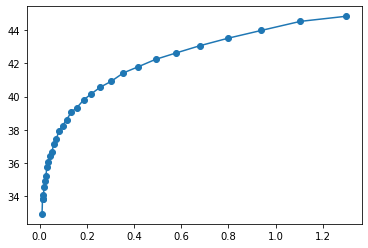

In [ ]:
z = snd[0]
mu = snd[1]
plt.plot(z,mu,'o',linestyle='-')

### **MCMC sampling**

**Covariance matrix**

In [ ]:
cov = np.reshape(cov,(nSn,nSn))         #reshaping (961,1) to (31,31)
invc = np.empty((nSn,nSn))
invc = np.linalg.inv(cov)               #inverse of the covariance matrix

**Likelihood and other require functions**

In [ ]:
def eta(a,Om):
  s = ((1-Om)/Om)**(1/3)
  eta1 = 2*mt.sqrt(s**3 + 1)*(1/a**4-0.154*s/a**3+0.4304*s**2/a**2+0.19097*s**3/a+0.066941*s**4)**(-1/8)
  return eta1

def  Dls(z,Om):
  D = (c*(1+z)/H0)*(eta(1,Om)-eta(1/(1+z),Om))      #Distance at h=1
  return D

def mu_m(h,z,Om):
  mu_m = 25 - 5*np.log10(h)+5*np.log10(Dls(z,Om))       #distance modulus
  return mu_m

#Likelihood distribution in log-scale
def likl(Om,h):
  if (Om<=0 or h<=0 or Om>1 or h>1):
    likl = -1.e100
  else:     
    for j in range(nSn):
      muv[j] = mu[j] - mu_m(h,z[j],Om)
    likl = -0.5*np.dot(muv,np.dot(invc,muv))  
  return likl 

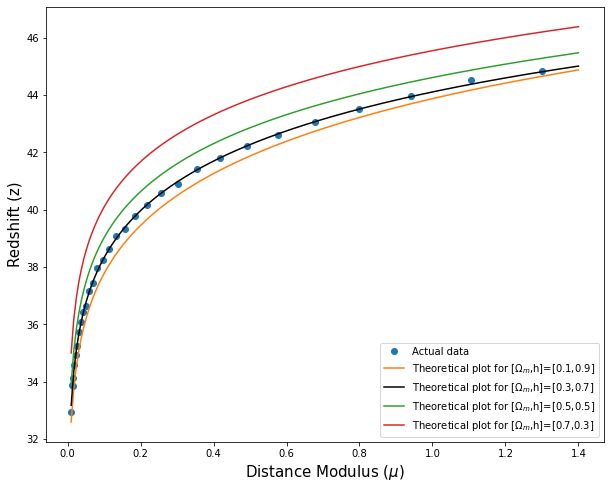

In [ ]:
N = 200
z_lin = np.linspace(0.01,1.4,N)
mu_plot0 = np.zeros(N) 
mu_plot1 = np.zeros(N)
mu_plot2 = np.zeros(N)
mu_plot3 = np.zeros(N)
for i in range(N):
  mu_plot0[i] = mu_m(0.9,z_lin[i],0.1)
  mu_plot1[i] = mu_m(0.7,z_lin[i],0.3)
  mu_plot2[i] = mu_m(0.5,z_lin[i],0.5)
  mu_plot3[i] = mu_m(0.3,z_lin[i],0.7)
fig, ax = plt.subplots(figsize=(10,8))  
ax.plot(z,mu,'o', label ='Actual data')
ax.plot(z_lin,mu_plot0,label ='Theoretical plot for [$\Omega_{m}$,h]=[0.1,0.9]')
ax.plot(z_lin,mu_plot1,color='k',label ='Theoretical plot for [$\Omega_{m}$,h]=[0.3,0.7]')
ax.plot(z_lin,mu_plot2,label ='Theoretical plot for [$\Omega_{m}$,h]=[0.5,0.5]')
ax.plot(z_lin,mu_plot3,label ='Theoretical plot for [$\Omega_{m}$,h]=[0.7,0.3]')
ax.legend()
ax.set_xlabel('Distance Modulus ($\mu$)',fontsize=15)
ax.set_ylabel('Redshift (z)', fontsize=15)
plt.savefig("zvsmu.jpg", format='jpg')

**Metropolis Hastings algorithm**

In [ ]:
def MH(initial,sigma):
  global accp
  global rej
  sigOm, sigh = sigma
  Om0,h0 = initial 
  htrial = np.random.normal(h0,sigh)              #drawing trial point considering a gaussian centered at previous point
  Omtrial = np.random.normal(Om0,sigOm) 
  u = np.log(np.random.uniform())
  accept = likl(Omtrial,htrial)-likl(Om0,h0)      #minus in between since it is log-scaled
  if accept>0:
    hnew = htrial
    Omnew = Omtrial
    a = 1                   #flags to 1 if the point is accepted
    paras = [Omnew,hnew]
    accp = [Omnew,hnew]           #stores all the accepted points
    # targ = likl(Omtrial,htrial)
  else:  
    if u<=accept:
      hnew = htrial
      Omnew = Omtrial
      a = 1
      paras = [Omnew,hnew]
      accp = [Omnew,hnew]
      # targ = likl(Omtrial,htrial)
    else:
      hnew = h0
      Omnew = Om0
      a = 0         #flags to 0 if the point is rejected
      paras = [Omnew,hnew]
      rej = [Omtrial,htrial]  #stores all the rejected points
      # targ = likl(Omtrial,htrial)
  return paras, a,accp,rej

In [ ]:
#loop to run the MH sampling for Ns samples
for i in range(Ns-1):
  pars[i+1],a, accept[i+1],reject[i+1] = MH(pars[i],sig) 
  acc = acc + np.array((a,1))  

**Acceptance and Rejection**

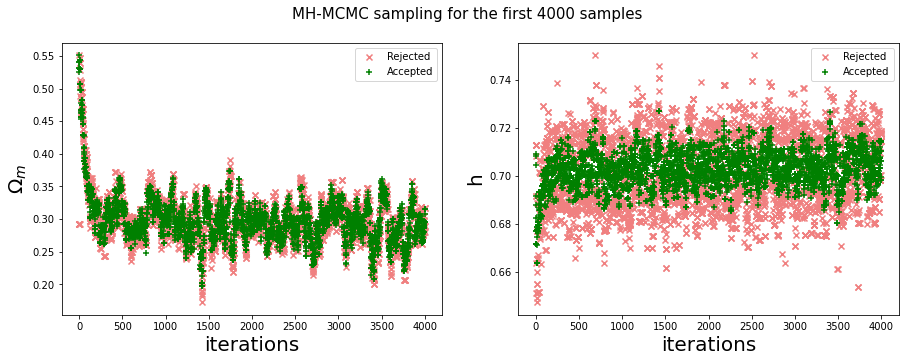

In [ ]:
n = 0.2
Ns25 = int(n*Ns)
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(np.linspace(0,Ns25,Ns25),reject[0:Ns25:,0],color='lightcoral',marker="x", label = 'Rejected')
axs[0].scatter(np.linspace(0,Ns25,Ns25),accept[0:Ns25:,0],color='g', marker = "+", label = 'Accepted')
axs[1].scatter(np.linspace(0,Ns25,Ns25),reject[0:Ns25:,1],color='lightcoral',marker="x", label = 'Rejected')
axs[1].scatter(np.linspace(0,Ns25,Ns25),accept[0:Ns25:,1],color='g', marker = "+", label = 'Accepted')
axs[0].set_xlabel('iterations', fontsize = 20)
axs[0].set_ylabel('$\Omega_{m}$', fontsize = 20)
axs[1].set_xlabel('iterations', fontsize = 20)
axs[1].set_ylabel('h', fontsize = 20)
axs[0].legend()
axs[1].legend()
# axs[0].set_ylim(0.4,0.7)
# axs[1].set_ylim(0.6,0.8)
fig.suptitle('MH-MCMC sampling for the first %d samples' %Ns25, fontsize = 15)
plt.savefig("acc&rej.jpg", format='jpg')

**Numerical values**

In [ ]:
mean_Om = np.mean(pars[nburn:,0])     #mean of Om
mean_h = np.mean(pars[nburn:,1])      #mean of h
std_Om = np.std(pars[nburn:,0])       #standard deviation of Om
std_h = np.std(pars[nburn:,1])        #standard deviation of h
paras = np.stack((pars[nburn:,0],pars[nburn:,1]))
cov = np.cov(paras)                   #covariance of Om and h
print([mean_Om,std_Om],[mean_h,std_h],cov)

[0.29504530252477434, 0.031211443730147597] [0.7031010151039302, 0.0070200646626496594] [[ 9.74208342e-04 -1.33976578e-04]
 [-1.33976578e-04  4.92840459e-05]]


In [ ]:
accept_avg = acc[0]/acc[1]    #average acceptance
accept_avg,acc

(0.5134256712835642, array([10268., 19999.]))

**Joint and Marginal Distribution**

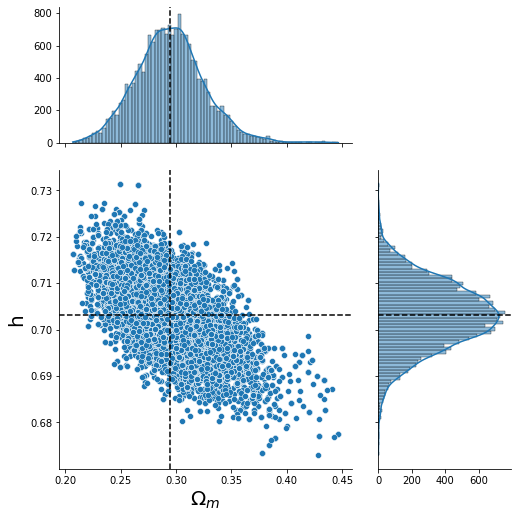

In [ ]:
g = sns.JointGrid(data=pars, x=pars[nburn:,0], y=pars[nburn:,1], height=7, ratio=2, marginal_ticks=True)
g.plot_joint(sns.scatterplot)
g.plot_marginals(sns.histplot, kde=True)
g.refline(x=mean_Om, y=mean_h,color='k')
g.set_axis_labels(xlabel='$\Omega_{m}$', ylabel='h', fontsize=20)
g.savefig("Joint_Dist.jpg", format='jpg')

**Convergence Test**

In [ ]:
pars1 = np.zeros([Ns,npar])
pars1[0] = [1,1]

pars2 = np.zeros([Ns,npar])
pars2[0] = [0,0]

pars3 = np.zeros([Ns,npar])
pars3[0] = [0.1,0.2]

In [ ]:
accept1 = np.zeros([Ns,npar])
reject1 = np.zeros([Ns,npar])
for i in range(Ns-1):
  pars1[i+1],a, accept1[i+1],reject1[i+1] = MH(pars1[i],sig)  

In [ ]:
accept2 = np.zeros([Ns,npar])
reject2 = np.zeros([Ns,npar])
for i in range(Ns-1):
  pars2[i+1],a, accept2[i+1],reject2[i+1] = MH(pars2[i],sig) 

In [ ]:
accept3 = np.zeros([Ns,npar])
reject3 = np.zeros([Ns,npar])
for i in range(Ns-1):
  pars3[i+1],a, accept3[i+1],reject3[i+1] = MH(pars3[i],sig)  

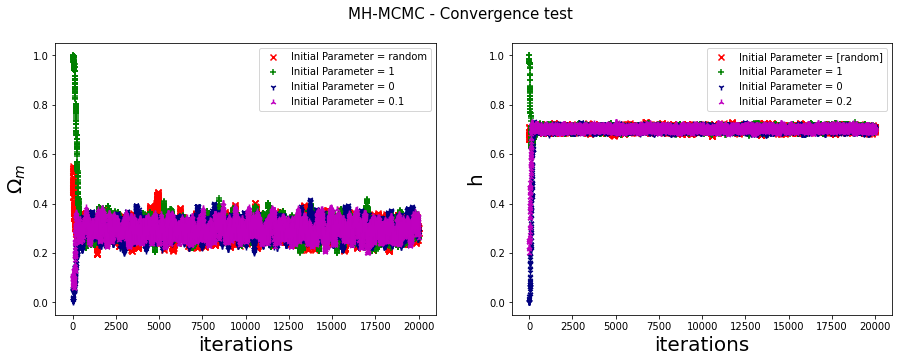

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
axs[0].scatter(np.linspace(0,Ns,Ns),pars[:,0],color='r',marker="x", label = 'Initial Parameter = random')
axs[0].scatter(np.linspace(0,Ns,Ns),pars1[:,0],color='g', marker = "+", label = 'Initial Parameter = 1')
axs[0].scatter(np.linspace(0,Ns,Ns),pars2[:,0],color='navy',marker="1", label = 'Initial Parameter = 0')
axs[0].scatter(np.linspace(0,Ns,Ns),pars3[:,0],color='m', marker = "2", label = 'Initial Parameter = 0.1')
axs[1].scatter(np.linspace(0,Ns,Ns),pars[:,1],color='r',marker="x", label = 'Initial Parameter = [random]')
axs[1].scatter(np.linspace(0,Ns,Ns),pars1[:,1],color='g', marker = "+", label = 'Initial Parameter = 1')
axs[1].scatter(np.linspace(0,Ns,Ns),pars2[:,1],color='navy',marker="1", label = 'Initial Parameter = 0')
axs[1].scatter(np.linspace(0,Ns,Ns),pars3[:,1],color='m', marker = "2", label = 'Initial Parameter = 0.2')
axs[0].set_xlabel('iterations', fontsize = 20)
axs[0].set_ylabel('$\Omega_{m}$', fontsize = 20)
axs[1].set_xlabel('iterations', fontsize = 20)
axs[1].set_ylabel('h', fontsize = 20)
axs[0].legend()
axs[1].legend()
fig.suptitle('MH-MCMC - Convergence test', fontsize = 15)
plt.savefig("Converge.jpg", format='jpg')

**Numerical Values corresponding to different starting points**

Mean and Standard Deviation

In [ ]:
param_Om = [pars[nburn:,0],pars1[nburn:,0],pars2[nburn:,0],pars3[nburn:,0]]
param_h = [pars[nburn:,1],pars1[nburn:,1],pars2[nburn:,1],pars3[nburn:,1]]
mean_Om = np.zeros(len(param_Om))
mean_h = np.zeros(len(param_Om))
std_Om = np.zeros(len(param_Om))
std_h = np.zeros(len(param_Om))
for i in range(len(param_Om)):
  mean_Om[i] = np.mean(param_Om[i])
  mean_h[i] = np.mean(param_h[i])
  std_Om[i] = np.std(param_Om[i])
  std_h[i] = np.std(param_h[i])
net_mean_Om = np.mean(mean_Om)            #mean of means of 4 different Om experiments
net_mean_h = np.mean(mean_h)              #mean of means of 4 different h experiments
net_std_mean_Om = np.mean(std_Om)         #standard deviation of means of 4 different Om experiments
net_std_mean_h = np.mean(std_h)           #standard deviation of means of 4 different h experiments
net_std_Om = np.std(std_Om)
net_std_h = np.std(std_h)
print([mean_Om,std_Om],[mean_h,std_h])
print([net_mean_Om,net_std_mean_Om,net_std_Om],[net_mean_h,net_std_mean_h,net_std_h])

[array([0.2950453 , 0.29760188, 0.29715166, 0.29515111]), array([0.03121144, 0.03206626, 0.03113864, 0.03017314])] [array([0.70310102, 0.70277397, 0.70310737, 0.7031381 ]), array([0.00702006, 0.00732229, 0.00713366, 0.00708053])]
[0.2962374872522444, 0.031147370707614842, 0.0006703839276821138] [0.7030301126975955, 0.007139134330998274, 0.00011312220330395991]
